In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import anndata as ad
from muon import prot as pt
import squidpy as sq
import scanpy as sc
import plotnine as p9
import decoupler as dc

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import liana as li
from liana.method import MistyData
li.__version__

'1.0.5'

In [3]:
rna_path = "data/GSE213264/GSM6578062_humantonsil_RNA.tsv.gz"
prot_path = "data/GSE213264/GSM6578071_humantonsil_protein.tsv.gz"

In [4]:
rna = pd.read_csv(rna_path, sep="\t")
prot = pd.read_csv(prot_path, sep="\t")
assert set(rna.X) == set(prot.X)

rna = rna.set_index("X")
prot = prot.set_index("X")
prot = prot.loc[rna.index]
assert np.all(rna.index == prot.index)

In [5]:
manual_dict = {"CD340..erbB2_HER.2": "HER2",
               "Mac.2..Galectin.3": "LGALS3",
               "CD158d..KIR2DL4": "KIR2DL4",
               "CD324..E.Cadherin": "E-Cadherin",
               "CD73..Ecto.5..nucleotidase": "NT5E",
               "CD81..TAPA.1": "CD81",
               "CD206..MMR": "CD206",
               "CD171..LICAM": "CD171",
               "CD200..OX2": "CD200",
               "CD279..PD.1": "PD-1",
               "CD138..Syndecan.1": "SDC1",
               "Ig.light.chain.Lambda": "Ig.light.chain.l",
               "TSLPR..TSLP.R": "TSLPR",
               "Cadherin.11": "CDH11",
               "HLA.DR_.DP_.DQ": "HLA.DR.DP.DQ",
               "CD90..Thy1": "CD90",
               "CD271..NGFR": "p75NTR"
               }

# clean protein names
cleaned_names = prot.columns
cleaned_names = [re.sub("\\.[AGCT]{15}", "", s) for s in prot.columns]
cleaned_names = [re.sub("anti\\.mouse\\.human", "", s) for s in cleaned_names]
cleaned_names = [re.sub("anti\\.human\\.mouse", "", s) for s in cleaned_names]
cleaned_names = [re.sub("anti\\.mouse\\.rat\\.human", "", s) for s in cleaned_names]
cleaned_names = [re.sub("anti\\.mouse\\.rat", "", s) for s in cleaned_names]
cleaned_names = [re.sub("human_mouse\\.", "", s) for s in cleaned_names]
cleaned_names = [re.sub("Mouse", "", s) for s in cleaned_names]
cleaned_names = [re.sub("Rat", "", s) for s in cleaned_names]
cleaned_names = [re.sub("Human", "", s) for s in cleaned_names]
cleaned_names = [re.sub("isotype\\.Ctrl", "", s) for s in cleaned_names]
cleaned_names = [re.sub("Isotype\\.Ctrl", "", s) for s in cleaned_names]
cleaned_names = [re.sub("\\.\\.k", "", s) for s in cleaned_names]
cleaned_names = [re.sub("\\.+$", "", s) for s in cleaned_names]
cleaned_names = [re.sub("^\\.+", "", s) for s in cleaned_names]
cleaned_names = [manual_dict[s] if s in manual_dict.keys() else s for s in cleaned_names]
prot.columns = cleaned_names

In [6]:
# get the coordinates
spatial = pd.DataFrame({"id": rna.index.copy(),
                        "x": np.array([int(s.split("x")[0]) for s in rna.index]), 
                        "y": np.array([int(s.split("x")[1]) for s in rna.index])}).set_index("id")
spatial

x   y
id           
29x42  29  42
44x36  44  36
34x6   34   6
42x19  42  19
41x6   41   6
...    ..  ..
2x26    2  26
30x26  30  26
23x48  23  48
8x44    8  44
5x44    5  44

[2492 rows x 2 columns]

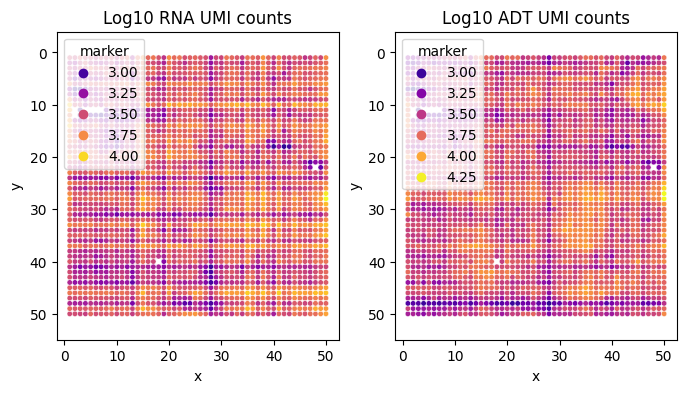

In [7]:
# QC plots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plot_df = spatial.copy()
plot_df["marker"] = np.log10(rna.sum(axis=1))
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[0], s=15, palette="plasma")
axs[0].axis('equal')
axs[0].invert_yaxis()
axs[0].set_title("Log10 RNA UMI counts")

plot_df = spatial.copy()
plot_df["marker"] = np.log10(prot.sum(axis=1))
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[1], s=15, palette="plasma")
axs[1].axis('equal')
axs[1].invert_yaxis()
axs[1].set_title("Log10 ADT UMI counts")
plt.show()

In [8]:
# remove spike ins from rna
print(rna.shape)
spike_bool = np.array(["ERCC" in c for c in rna.columns])
print(spike_bool.sum())
rna = rna.loc[:,~spike_bool]
print(rna.shape)

# remove unmapped from protein
print(prot.shape)
unmapped_bool = np.array(["unmapped" in c for c in prot.columns])
print(unmapped_bool.sum())
prot = prot.loc[:,~unmapped_bool]
print(prot.shape)

(2492, 28417)
29
(2492, 28388)
(2492, 283)
1
(2492, 282)


In [9]:
# make RNA adata object
rna_ad = sc.AnnData(X=rna.values,
                    obs=rna.index.to_frame(name="id"), 
                    var=rna.columns.to_frame(name="gene"),
                    obsm={"spatial": spatial})
sc.pp.filter_genes(rna_ad, min_cells=10)
sc.pp.filter_cells(rna_ad, min_genes=100)

sc.pp.normalize_total(rna_ad, target_sum=1e4)
sc.pp.log1p(rna_ad)
rna_ad.raw = rna_ad
rna_ad

/tmp/ipykernel_3072148/1890789175.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 2492 × 16727
    obs: 'id', 'n_genes'
    var: 'gene', 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'

In [10]:
# # infer hallmarks
# msigdb = dc.get_resource('MSigDB')
# hallmark = msigdb[msigdb['collection']=='hallmark'] # filter by hallmark
# hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])] # remove duplicates
# hallmark.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in hallmark['geneset']] # rename for consistency
# hallmark = hallmark.loc[:, ['geneset', 'genesymbol']] # reorder columns

# dc.run_ulm(
#     mat=rna_ad,
#     net=hallmark,
#     source="geneset",
#     target="genesymbol",
#     weight=None,
#     verbose=True,
#     use_raw=False
# )

# acts = li.ut.obsm_to_adata(rna_ad, 'ulm_estimate')

In [11]:
# infer tfs
net = dc.get_dorothea() # NOTE: why dorothea xD
dc.run_ulm(
    mat=rna_ad,
    net=net,
    source="source",
    target="target",
    verbose=True,
    use_raw=False
)

acts = li.ut.obsm_to_adata(rna_ad, 'ulm_estimate')

198MB [00:02, 103MB/s]  


Running ulm on mat with 2492 samples and 16727 targets for 288 sources.


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


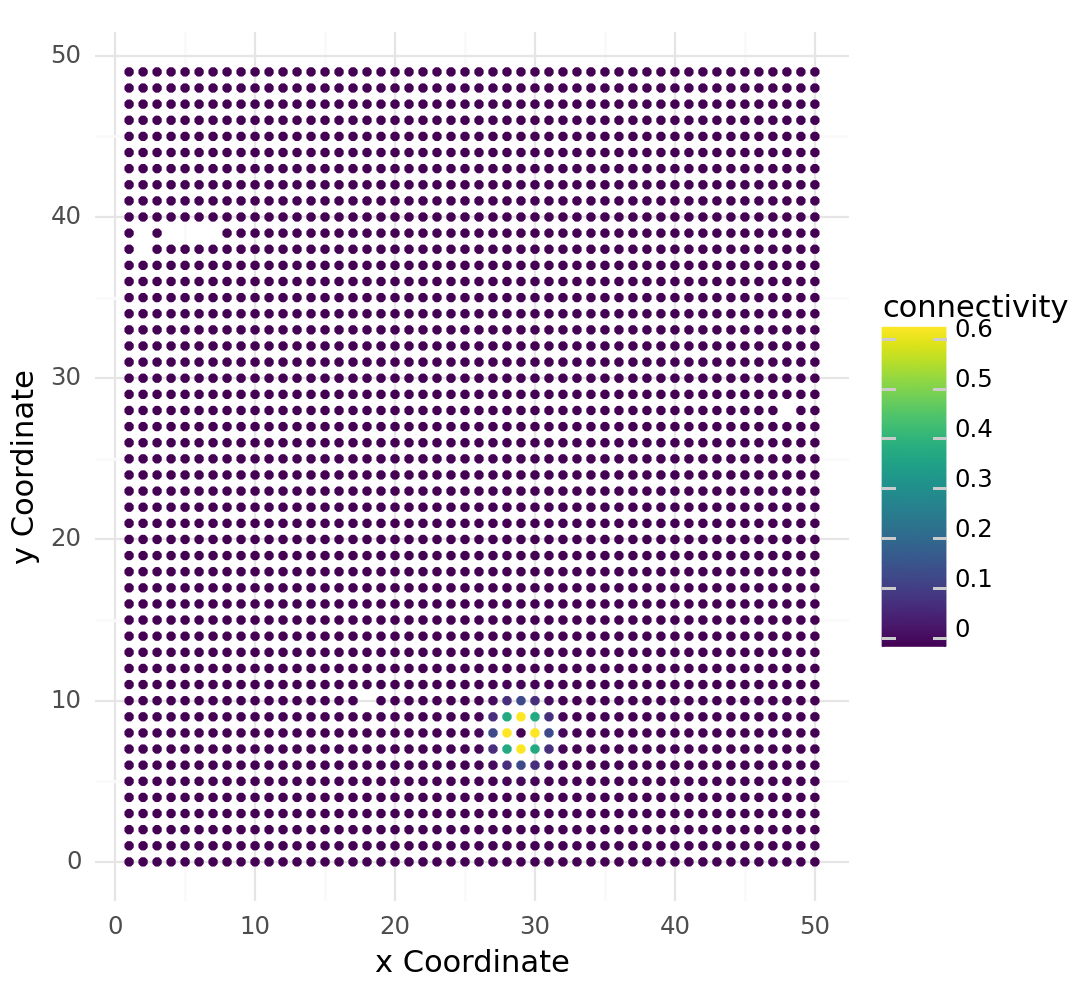

<Figure Size: (540 x 500)>

In [12]:
li.ut.spatial_neighbors(acts, cutoff=0, bandwidth=1, set_diag=False)
li.pl.connectivity(acts, idx=0)

In [13]:
prot_ad = sc.AnnData(X=prot.values, 
                     obs=prot.index.to_frame(name="id"),
                     var=prot.columns.to_frame(name="protein"),
                     obsm={"spatial": spatial})
# sc.pp.normalize_total(prot_ad, target_sum=1e4)
mu.prot.pp.clr(prot_ad)

/tmp/ipykernel_3072148/1905832566.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
misty = MistyData(data={"intra": prot_ad, "para": acts})
misty.var_names_make_unique() # otherwise we cannot index
misty

/home/dbdimitrov/.local/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
view intra is not a csr_matrix. Converting to csr_matrix
view para is not a csr_matrix. Converting to csr_matrix


MuData object with n_obs × n_vars = 2492 × 570
  obs:	'id'
  2 modalities
    intra:	2492 x 282
      obs:	'id'
      var:	'protein'
      obsm:	'spatial'
    para:	2492 x 288
      obs:	'id', 'n_genes'
      uns:	'log1p'
      obsm:	'spatial', 'ulm_estimate', 'ulm_pvals'
      obsp:	'spatial_connectivities'

In [15]:
misty(model="linear", verbose=True, bypass_intra=True)

Now learning: HLA.DR.DP.DQ: 100%|██████████| 282/282 [01:37<00:00,  2.90it/s]                 


/home/dbdimitrov/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 4 in image.
/home/dbdimitrov/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/multi_R2.pdf


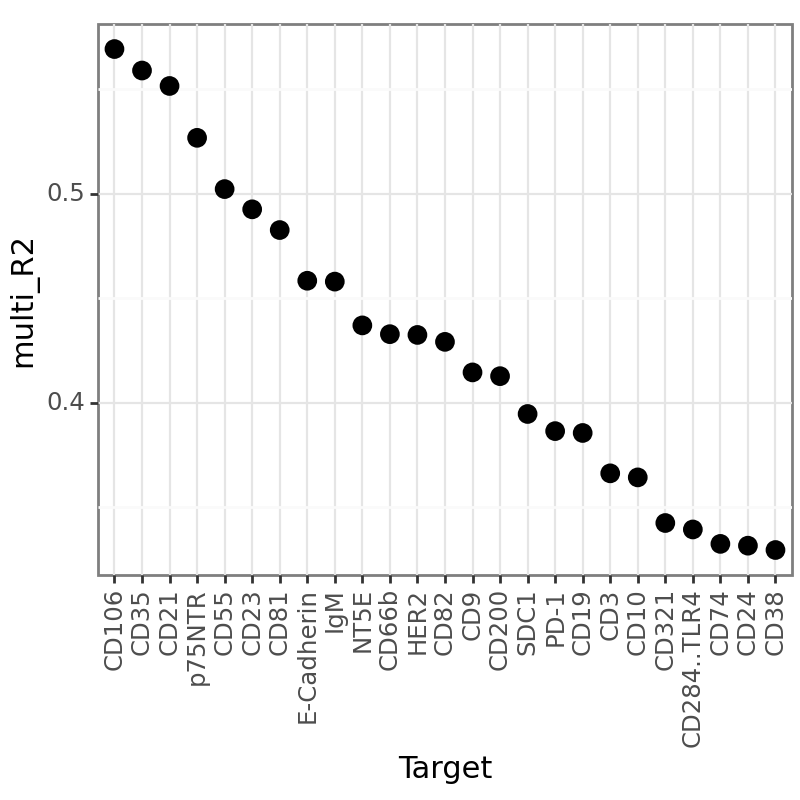

<Figure Size: (400 x 400)>

In [16]:
stat = "multi_R2"
target_metrics = misty.uns['target_metrics'].copy()

target_metrics = target_metrics.sort_values(stat, ascending=False).head(25)

# get order of target by decreasing intra.R2
targets = target_metrics.sort_values(by=stat, ascending=False)['target'].values
# targets as categorical variable
target_metrics['target'] = pd.Categorical(target_metrics['target'],
                                          categories=targets, 
                                          ordered=True)

p = (p9.ggplot(target_metrics, p9.aes(x='target', y=stat)) +
        p9.geom_point(size=3) + 
        # p9.geom_hline(yintercept=0.45, linetype='dashed') +
        p9.theme_bw() +
        p9.theme(axis_text_x=p9.element_text(rotation=90),
                figure_size=(4,4)) +
    p9.labs(x='Target')
    )
p.save('figures/multi_R2.pdf', height=4, width=4)
p

/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/dbdimitrov/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is depr

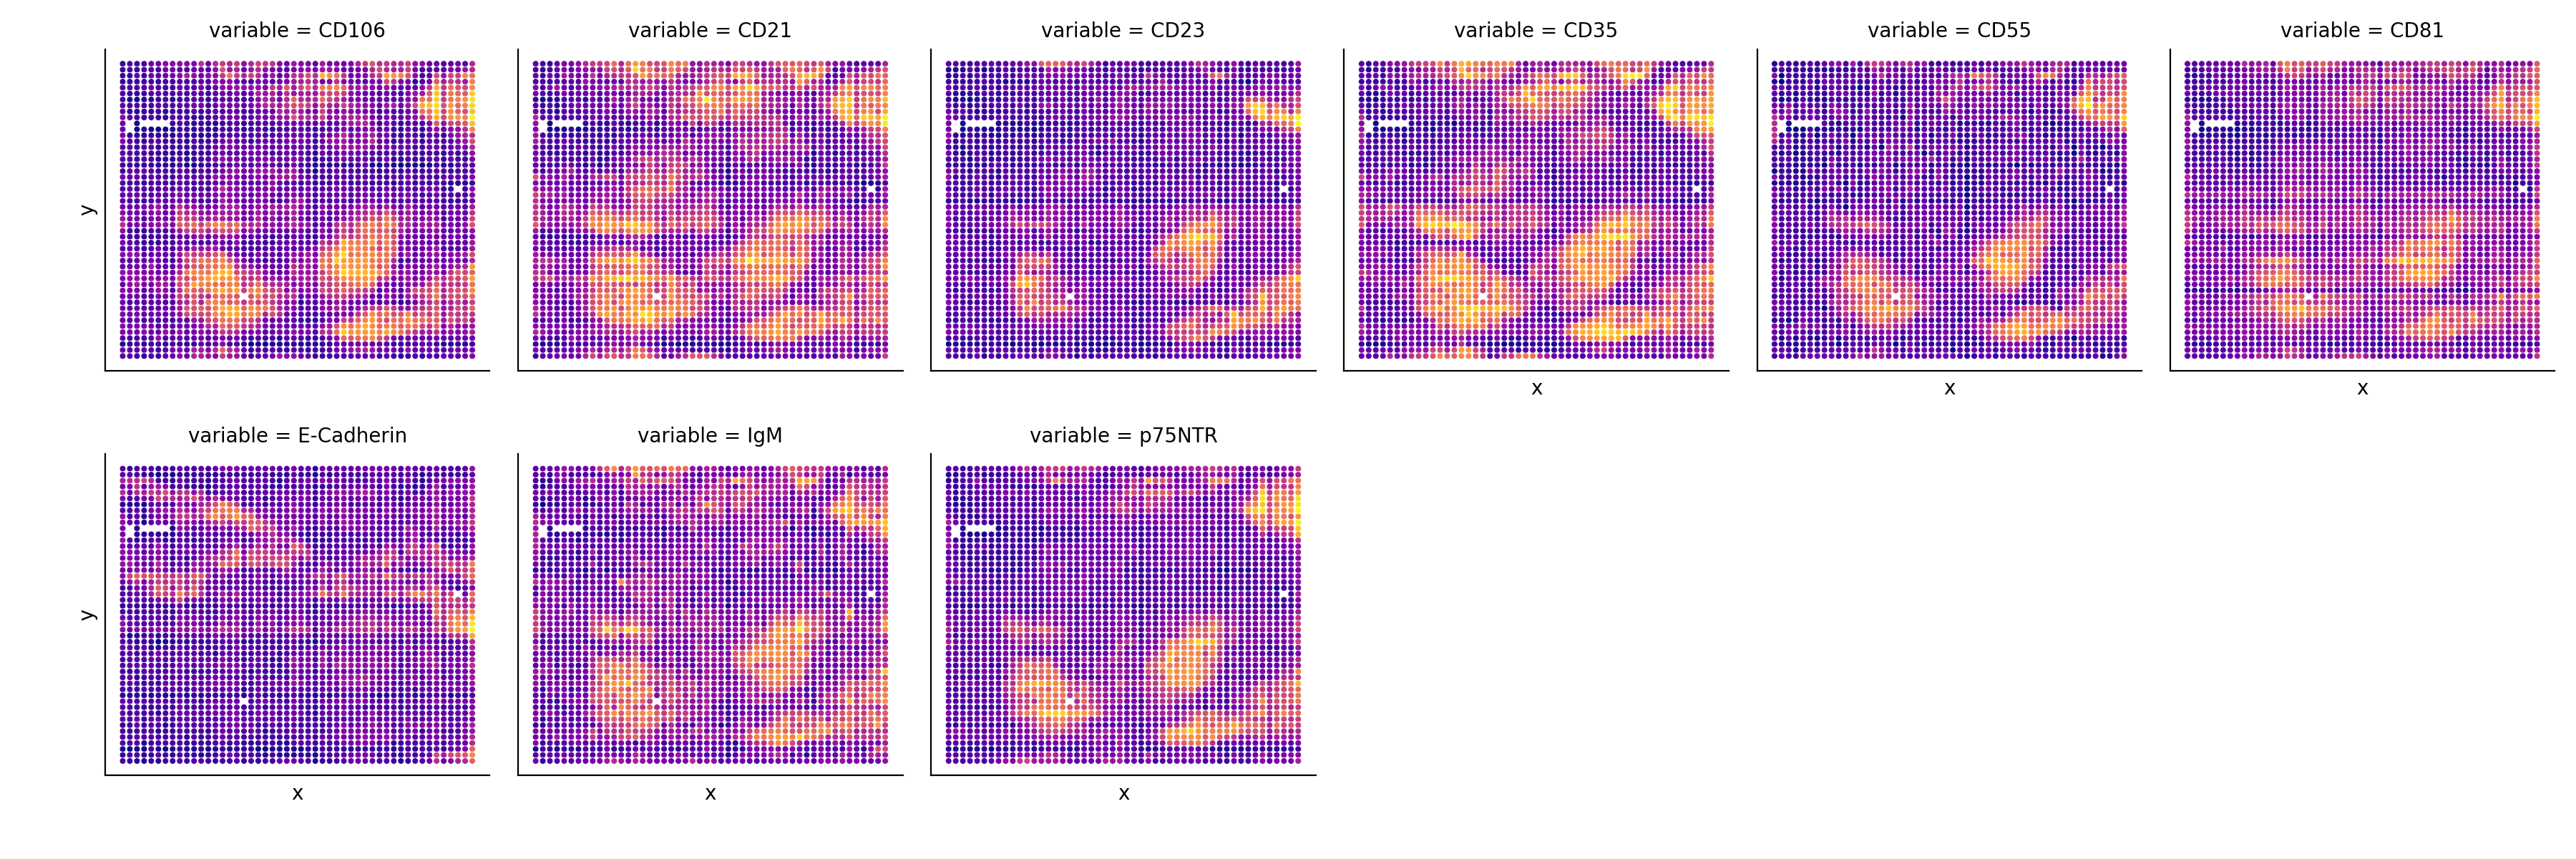

In [17]:
# plot the proteins
df_prot = pd.DataFrame(prot_ad.X.todense(),
                       index=prot_ad.obs.index,
                       columns=prot_ad.var.index).reset_index().melt(id_vars="X")

df_prot = df_prot.groupby(["X", "variable"]).mean().reset_index()

df_prot["x"] = np.array([int(s.split("x")[0]) for s in df_prot.X])
df_prot["y"] = np.array([int(s.split("x")[1]) for s in df_prot.X]) * (-1) # invert y-axis

df_prot = df_prot.loc[np.isin(df_prot.variable, target_metrics.target.to_numpy()[target_metrics.multi_R2.to_numpy() > 0.45])]

g = sns.FacetGrid(data=df_prot, col="variable", col_wrap=6)
g.map(sns.scatterplot, "x", "y", "value", s=10, palette="plasma")
for ax in g.axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

/home/dbdimitrov/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 4 in image.
/home/dbdimitrov/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/interactions.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


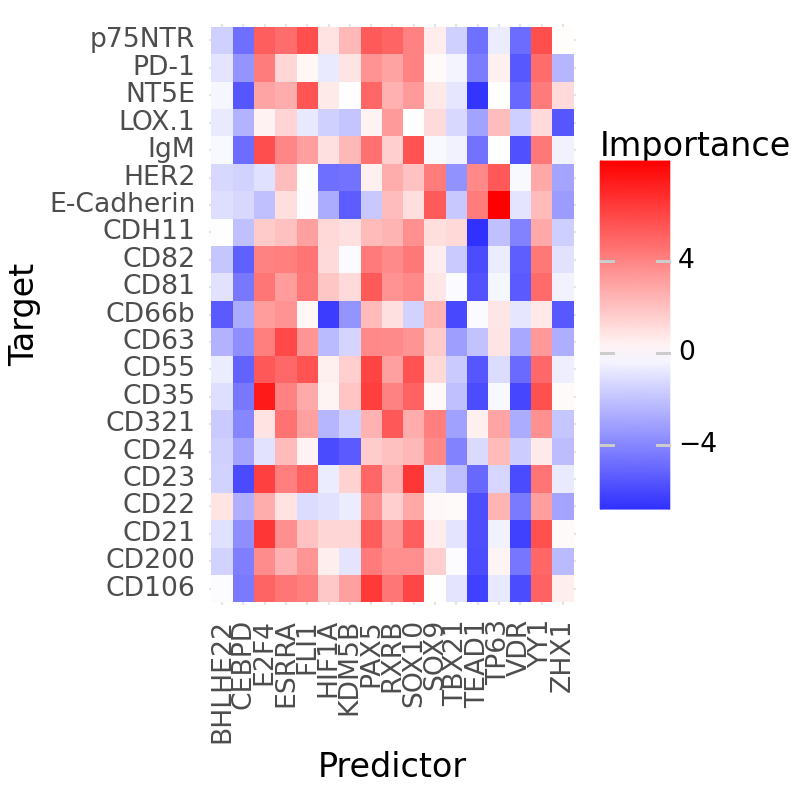

<Figure Size: (400 x 400)>

In [18]:
p = (li.pl.interactions(misty, view='para', top_n=50, key=abs) +
    p9.geom_tile() +
    p9.theme_minimal(base_size=12) +
    p9.theme(axis_text_x=p9.element_text(rotation=90),
            figure_size=(4, 4)) +
    p9.labs(x='Predictor', y='Target', fill='Importance') +
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    p9.labs(y='Target', x='Predictor')
)
p.save('figures/interactions.pdf')
p

In [19]:
interactions = misty.uns['interactions'].copy()
interactions = interactions[interactions['view'] == "para"]
grouped = interactions.groupby('predictor')['importances'].apply(lambda x: x.isna().all())
interactions = interactions[~interactions['predictor'].isin(grouped[grouped].index)]
interactions = interactions.sort_values(by='importances', key=None, ascending=False)
# only keep interactions for targets with R2 above X%
interactions = interactions.loc[np.isin(interactions.target, target_metrics.target[target_metrics.multi_R2 > 0.45])]
interactions.head(20)

target predictor  view  importances
13504  E-Cadherin      TP63  para     7.944624
26822        CD35      E2F4  para     7.092354
27287        CD23     SOX10  para     6.236133
22214        CD21      E2F4  para     6.207261
48269       CD106      PAX5  para     6.178400
26957        CD35      PAX5  para     5.989610
27110        CD23      E2F4  para     5.908555
61229        CD55      PAX5  para     5.807080
48311       CD106     SOX10  para     5.756721
70824      p75NTR       YY1  para     5.498082
40070         IgM      E2F4  para     5.480628
70621      p75NTR      FLI1  para     5.475980
27048        CD35       YY1  para     5.416308
22440        CD21       YY1  para     5.413951
61271        CD55     SOX10  para     5.369179
61117        CD55      FLI1  para     5.364188
40247         IgM     SOX10  para     5.344654
61094        CD55      E2F4  para     5.171378
13468  E-Cadherin      SOX9  para     5.130794
70733      p75NTR      PAX5  para     5.121799

In [20]:
# plot the top_n interactions as bivariate scores
top_n = 3
top_interactions = interactions.drop_duplicates(['target', 'predictor']).head(top_n)
interactions_subset = interactions[interactions['target'].isin(top_interactions['target']) & 
                                   interactions['predictor'].isin(top_interactions['predictor'])]
interactions_subset = list(zip(interactions_subset['target'], interactions_subset['predictor']))

In [21]:
interactions_subset

[('E-Cadherin', 'TP63'),
 ('CD35', 'E2F4'),
 ('CD23', 'SOX10'),
 ('CD23', 'E2F4'),
 ('CD35', 'SOX10'),
 ('E-Cadherin', 'SOX10'),
 ('CD35', 'TP63'),
 ('CD23', 'TP63'),
 ('E-Cadherin', 'E2F4')]

In [22]:
prot_cluster = misty.mod['intra']
sc.tl.pca(prot_cluster, svd_solver='arpack')
sc.pp.neighbors(prot_cluster, n_neighbors=10, n_pcs=20)
sc.tl.leiden(prot_cluster, resolution=0.3)

In [23]:


# get the extra view
acts_smoothed = acts.copy()
acts_smoothed.X = acts_smoothed.obsp["spatial_connectivities"]@acts_smoothed.X
acts_smoothed



AnnData object with n_obs × n_vars = 2492 × 288
    obs: 'id', 'n_genes'
    uns: 'log1p'
    obsm: 'spatial', 'ulm_estimate', 'ulm_pvals'
    obsp: 'spatial_connectivities'

/tmp/ipykernel_3072148/2013507357.py:57: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.


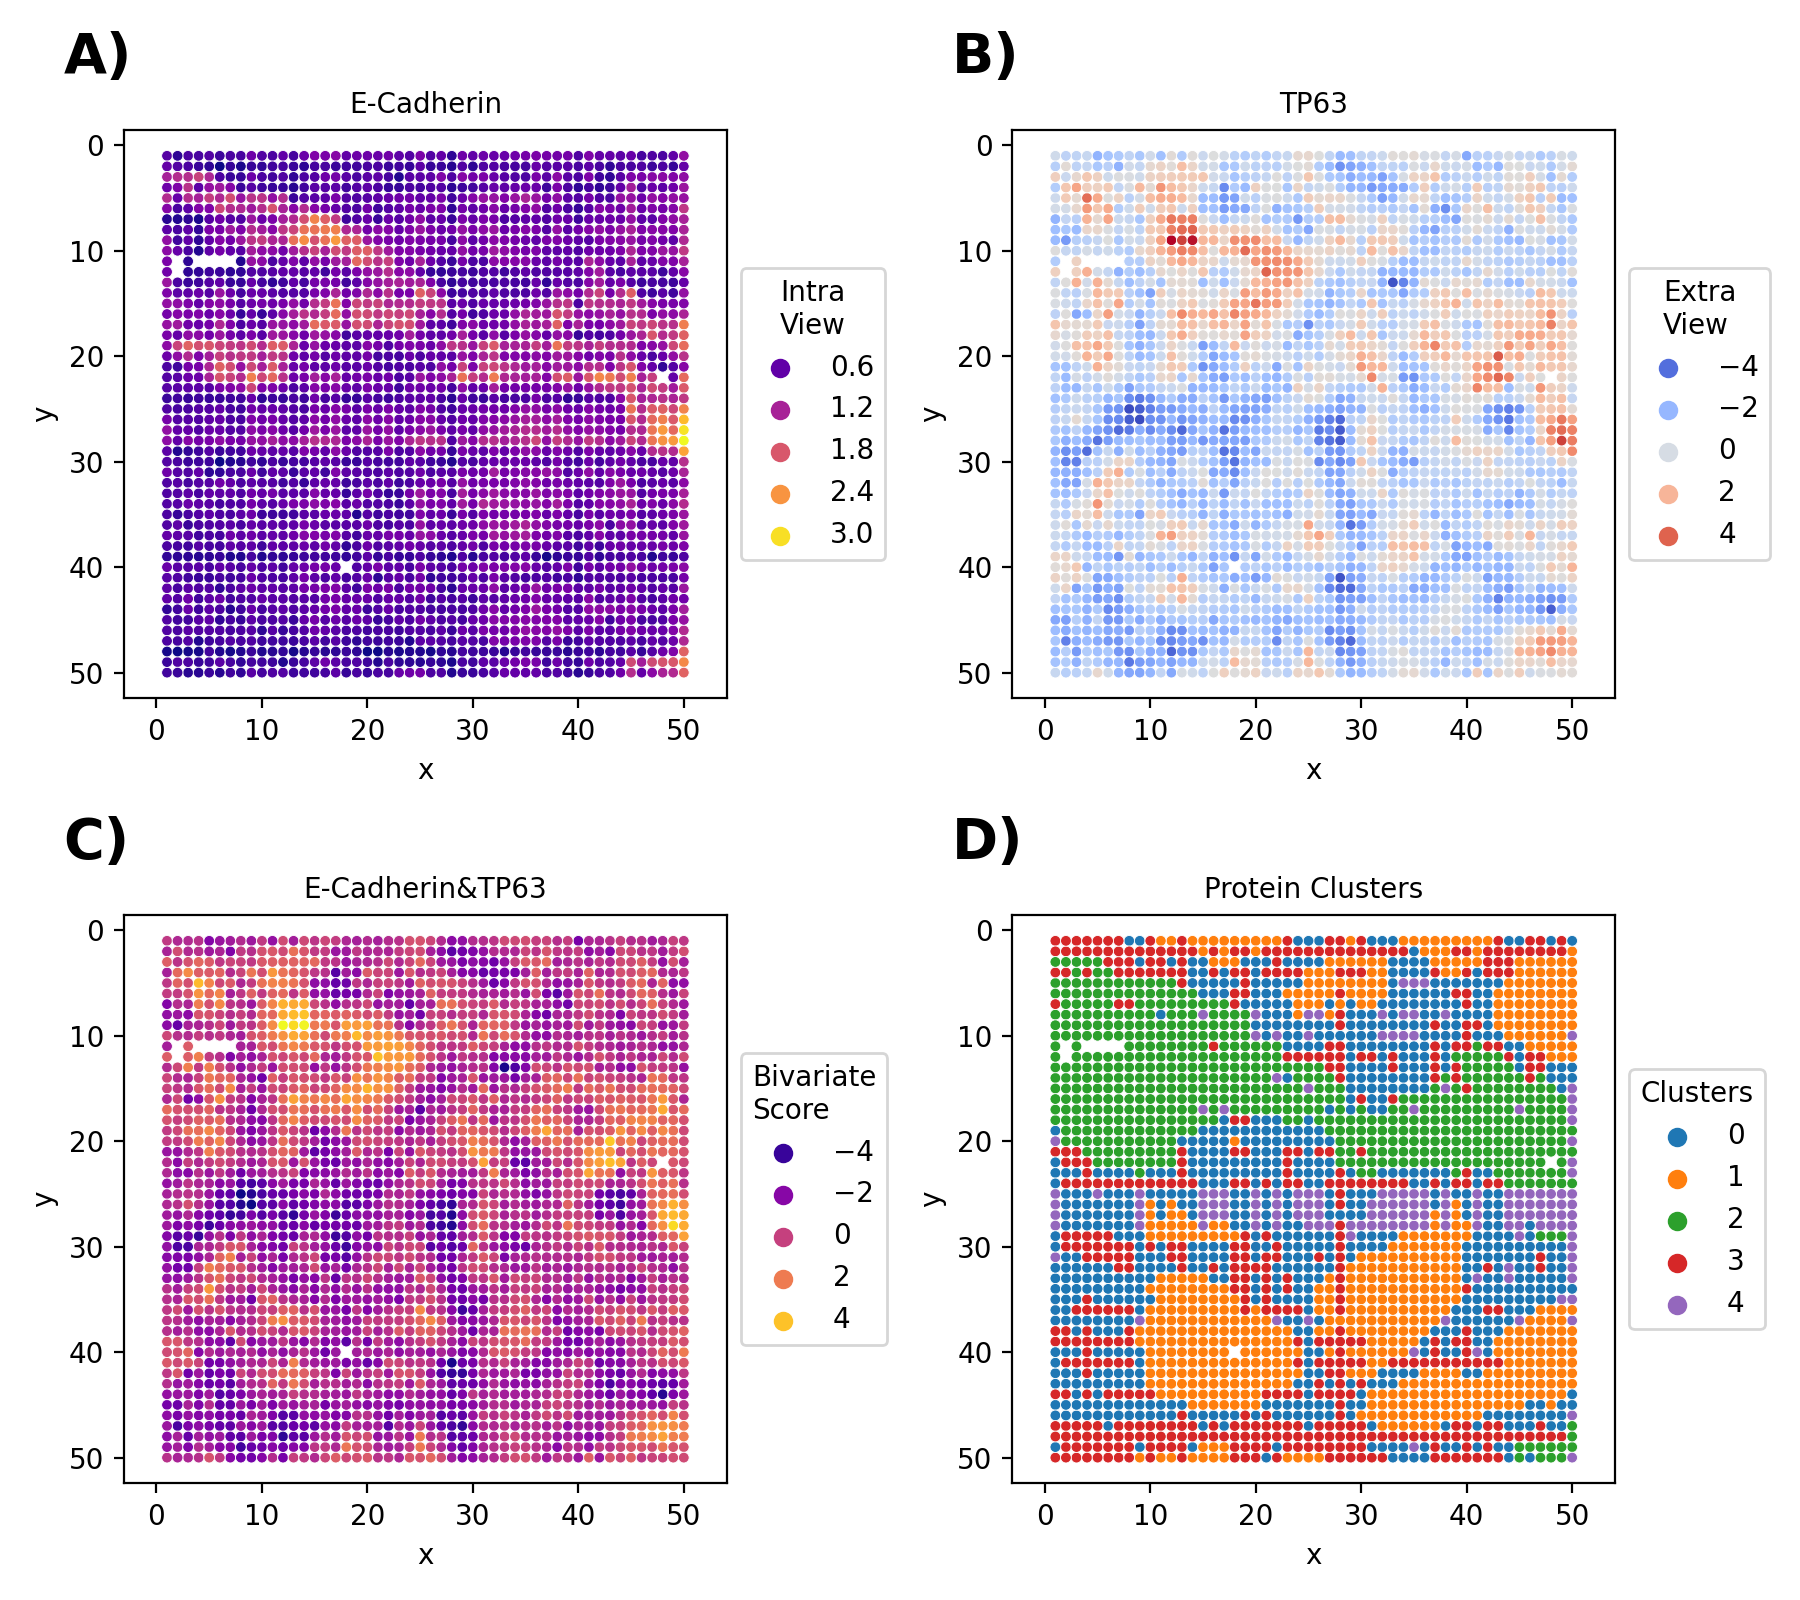

In [38]:
# manually
interactions_subset = [("E-Cadherin", "TP63")]

misty.obsm = misty.mod['para'].obsm.copy()
misty.obsp = misty.mod['para'].obsp.copy()

xy_sep = "&"

li.mt.bivar(misty,
            x_mod="intra",
            y_mod="para",
            x_transform=li.ut.zi_minmax,
            y_transform=li.ut.zi_minmax,
            function_name="cosine",
            interactions=interactions_subset,
            mask_negatives=True,
            add_categories=True,
            xy_sep=xy_sep,
            n_perms=2, # NOTE: FIX THIS
            x_use_raw=False,
            y_use_raw=False,
            )

# marker size
marker_size = 15
marker_shape = "o"

for i in range(len(interactions_subset)):
    var = misty.mod['local_scores'].var_names[i]
    var1 = var.split(xy_sep)[0]
    var2 = var.split(xy_sep)[1]

    fig, axs = plt.subplots(2, 2, figsize=(9, 8))
    axs = axs.flatten()
    # plot intra
    plot_df = misty.mod['intra'].obsm["spatial"]
    plot_df["marker"] = np.asarray(misty.mod['intra'][:, var1].X.todense()).squeeze()
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[0], palette="plasma", s=marker_size, marker=marker_shape)
    legend = axs[0].get_legend()
    axs[0].legend(title='Intra\nView', loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].axis('equal')
    axs[0].invert_yaxis()
    axs[0].set_title(var1, fontsize=10)

    # plot extra
    plot_df = misty.mod['para'].obsm["spatial"]
    plot_df["marker"] = acts_smoothed[:, var2].X.copy().toarray().flatten()
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[1], palette="coolwarm", s=marker_size, marker=marker_shape)
    legend = axs[1].get_legend()
    axs[1].legend(title='Extra\nView', loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].axis('equal')
    axs[1].invert_yaxis()
    axs[1].set_title(var2, fontsize=10)

    # plot bivariate
    plot_df = misty.mod['local_scores'].obsm["spatial"]
    plot_df["marker"] = misty.mod['local_scores'].X[:, i].A.flatten()
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[2], palette="plasma", s=marker_size, marker=marker_shape)
    legend = axs[2].get_legend()
    axs[2].legend(title='Bivariate\nScore', loc='center left', bbox_to_anchor=(1, 0.5))
    axs[2].axis('equal')
    axs[2].invert_yaxis()
    axs[2].set_title(var, fontsize=10)

    # plot protein clusters
    plot_df = prot_cluster.obsm["spatial"].copy()
    plot_df["marker"] = prot_cluster.obs["leiden"].values
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[3], s=marker_size, marker=marker_shape)
    legend = axs[3].get_legend()
    axs[3].legend(title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))
    axs[3].axis('equal')
    axs[3].invert_yaxis()
    axs[3].set_title("Protein Clusters", fontsize=10)

    # from: https://stackoverflow.com/questions/25543978/annotate-subplots-in-a-figure-with-a-b-c
    import string
    for n, ax in enumerate(axs):
        ax.text(-0.1, 1.1,
                f"{string.ascii_uppercase[n]})", 
                transform=ax.transAxes, 
                size=20, weight='bold')

    plt.tight_layout()
    fig.savefig(f"../figures/{var}.pdf", bbox_inches='tight')
    plt.show()